# Loading and normalizing CIFAR10

In [40]:
import torch
import torchvision
import torchvision.transforms as transforms

In [41]:
# transforms函數對圖像做預處理可以是：標準化(normalize)，尺寸剪裁(resize)，翻轉(flip)等。
# 這些步驟實際操作起來往往是一系列的，此時可以用compose將這些圖像預處理操作連起來。

# 將一個PIL圖像轉換為tensor
# 用均值（0.5, 0.5, 0.5）和標準差（0.5, 0.5, 0.5）對圖像做標準化處理
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [42]:
import matplotlib.pyplot as plt
import numpy as np

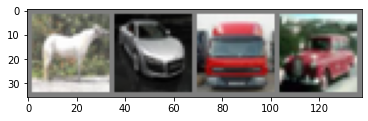

horse   car truck   car


In [43]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
 
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 定義網路

In [44]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# 定義損失函數和優化器

In [45]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 訓練網路

In [46]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            rinning_loss = 0.0
            
    print('Finished Training')

[1,  2000] loss: 2.214
[1,  4000] loss: 4.018
[1,  6000] loss: 5.660
[1,  8000] loss: 7.193
[1, 10000] loss: 8.685
[1, 12000] loss: 10.139
Finished Training
[2,  2000] loss: 1.377
[2,  4000] loss: 2.695
[2,  6000] loss: 3.994
[2,  8000] loss: 5.268
[2, 10000] loss: 6.520
[2, 12000] loss: 7.762
Finished Training


In [47]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# testing data測試網路

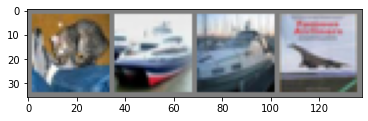

GroundTruth:    cat ship shipplane


In [48]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print image
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ''.join('%5s' % classes[labels[j]] for j in range(4)))

In [49]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


##### 網路在整個資料集上表現


In [50]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


##### 哪些是表現好的類呢？哪些是表現的差的類呢？


In [51]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
            
for i in range(10):
       print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 50 %
Accuracy of   car : 62 %
Accuracy of  bird : 55 %
Accuracy of   cat : 46 %
Accuracy of  deer : 28 %
Accuracy of   dog : 38 %
Accuracy of  frog : 75 %
Accuracy of horse : 59 %
Accuracy of  ship : 85 %
Accuracy of truck : 48 %


# Training on GPU


In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [53]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [54]:
inputs, labels = inputs.to(device), labels.to(device)
